# validation test for scalar diffusion with a constant source term
### this validation test follows "H K Versteeg and W Malalasekera, An Introduction to Computational Fluid Dynamics: THE FINITE VOLUME METHOD, Second Edition, 2007" examples 4.1,4.2

The temperature along a metal rod is given by this equation:

$T(x) = \left( \frac{T(L) - T(0)}{L} + \frac{S}{2k} (L-x) \right) x$

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import Odin

# write '4.1' or '4.2'
exampleId = '4.2'

# geometric parameters
LenX = {'4.1':0.5, '4.2':0.02}[exampleId]
LenY = {'4.1':0.1, '4.2':0.004}[exampleId]

# thermal conductivity [ W / (m K) ]
k = {'4.1':1000.0, '4.2':0.5}[exampleId]

# heat source [ W / m^3 ]
heatSource = {'4.1':0, '4.2':1e6}[exampleId]

# const temperature at left/right boundaries [K]
T_l = {'4.1':100, '4.2':100}[exampleId]
T_r = {'4.1':500, '4.2':200}[exampleId]

resolution = {'4.1':10, '4.2':250}[exampleId]
#resolution = {'4.1':10, '4.2':2500}[exampleId]

# the cross sectional area is hard coded in createMatrixCoefficients()
# the cross sectional area should be defined by the geometry/mesh
geom = Odin.createGeometry( 'rectangle', [LenX, LenY] )
mesh = Odin.createMesh( geom, res=resolution )

flowModels = {
    'T' : Odin.TransportModels.scalarTransport
}

#Defining passive velocity Fields:
passiveFields = {
    'u' : 'faces_u',
    'v' : 'faces_v'
}

sim = Odin.Simulation(flowModels,mesh, geom, passiveFields=passiveFields )

print(flowModels)

myFields = sim.fieldRegistry

myFields['T'].govModel.setDiffusionCoefficient(k)
#flowModels['T'].setDiffusionCoefficient(k)

# remove this. I already have a passive u,v field
#flowModels['T'].setConvectionField(values=(0.0,0.0))

print(myFields)

T = myFields['T']
print(T)
#boundaryDict = {}

# this could also be done before SIM is instanciated
Odin.defineBoundaryCondition(field=T, fieldReg=myFields, boundaryName='top', boundaryType='zeroGradient')
Odin.defineBoundaryCondition(field=T, fieldReg=myFields, boundaryName='bottom', boundaryType='zeroGradient')
Odin.defineBoundaryCondition(field=T, fieldReg=myFields, boundaryName='left', boundaryType='fixedValue', value=T_l )
Odin.defineBoundaryCondition(field=T, fieldReg=myFields, boundaryName='right', boundaryType='fixedValue', value=T_r )

Odin.updateSource(field=T, value=heatSource, mesh=mesh )

#T.solve()
T.data = Odin.solve(T)
print(T.data)

{'T': <class 'TransportModels.scalarTransport'>}
{'invCellDist': <Fields.fieldContainer object at 0x7fa5ca50e220>, 'T': <Fields.baseField object at 0x7fa5ca50e2e0>, 'u': <Fields.baseField object at 0x7fa5ca50e340>, 'v': <Fields.baseField object at 0x7fa5ca50e3a0>}
solving  <TransportModels.scalarTransport object at 0x7fa60f44a310>
[[150. 218. 254. 258. 230.]]


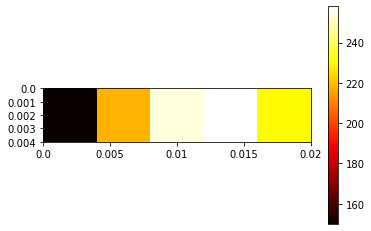

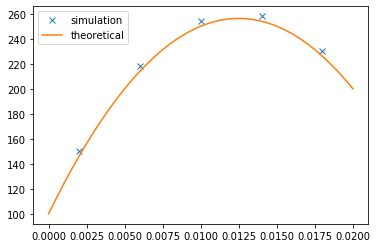

[150. 218. 254. 258. 230.]


In [2]:
# post-processing:
import numpy as np
import matplotlib.pyplot as plt

# the temperature along the x-axis should develop as:
def tempDistr( x ):
    return ((T_r-T_l)/LenX + S/(2*k)*(LenX-x))*x + T_l

sim.display(T, mesh)

nbcellsX = sim.mesh._cells_x
cellSpacing = sim.mesh._uniformSpacing
L = geom.lenX

xSim = np.linspace(0+0.5*cellSpacing,LenX-0.5*cellSpacing,nbcellsX)
ySim = T.data[0,:]

xTheo = np.linspace(0,LenX, 100)
S = np.ones(len(xTheo))*heatSource
yTheo = tempDistr(xTheo)

ax = plt.gca()
ax.plot(xSim, ySim, 'x', label='simulation')
ax.plot(xTheo, yTheo, label='theoretical')

plt.legend()
plt.show()

print(ySim)

In [ ]:
# shutting the interpreter down, so I can a fresh instance next time.
# my modules are automatically checked for updates
import os
os._exit(00)